In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

In [2]:
# Device configuration (for Mac; for Windows, use device:cuda instead)
device = torch.device(torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu"))
print(f"torch.backends.mps.is_available(): {torch.backends.mps.is_available()}")

# Hyper-parameters
num_epochs = 25
batch_size = 100
learning_rate = 0.001

# Image preprocessing modules
transform = transforms.Compose([
    transforms.Pad(4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32),
    transforms.ToTensor()])

# Download the CIFAR-10 dataset
train_dataset = torchvision.datasets.CIFAR10(root='../../data/',
                                             train=True, 
                                             transform=transform,
                                             download=True)

test_dataset = torchvision.datasets.CIFAR10(root='../../data/',
                                            train=False, 
                                            transform=transforms.ToTensor())

# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

torch.backends.mps.is_available(): True


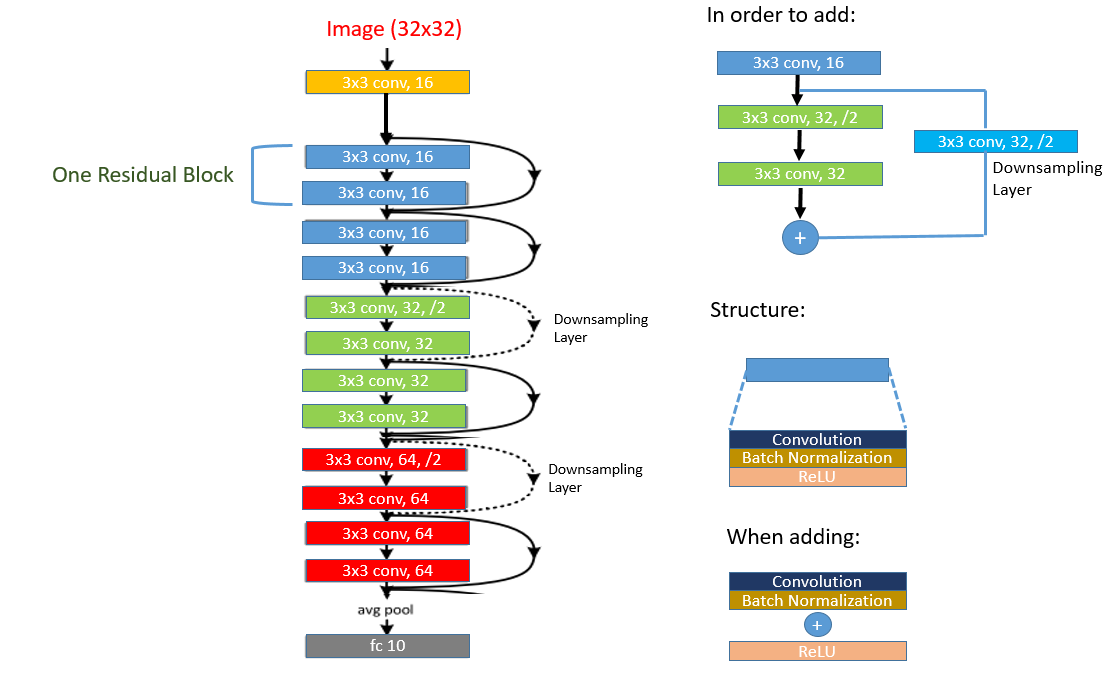

In [3]:
def conv3x3(in_channels, out_channels, stride=1):
    return nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)

In [4]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()

        self.conv1 = conv3x3(in_channels, out_channels, stride)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

        self.conv2 = conv3x3(out_channels, out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)
        return out

In [5]:
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=10):
        super(ResNet, self).__init__()
        self.in_channels = 16
        self.conv = conv3x3(3, 16)
        self.bn = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)
        
        self.layer1 = self.make_layer(block, 16, layers[0])
        self.layer2 = self.make_layer(block, 32, layers[1], 2)
        self.layer3 = self.make_layer(block, 64, layers[2], 2)
        
        self.avg_pool = nn.AvgPool2d((8, 8))
        self.fc = nn.Linear(64, num_classes)
    
    def forward(self, x):
        out = self.conv(x)
        out = self.bn(out)
        out = self.relu(out)

        # Add 3 residual layers of 2 blocks each
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)

        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        
        return out

    def make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if (stride > 1) or (self.in_channels != out_channels):
            downsample = nn.Sequential(
                conv3x3(self.in_channels, out_channels, stride=stride),
                nn.BatchNorm2d(out_channels)
            )

        layers = []
        # Let's add the first block, with/without downsampling
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels

        for i in range(1, blocks):  # Adding the second block onwards
            layers.append(block(out_channels, out_channels))

        return nn.Sequential(*layers)


In [6]:
# Build models and add optimizers
model = ResNet(ResidualBlock, [2, 2, 2]).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [7]:
# Train
decay = 0
model.train()
for epoch in range(num_epochs):
    if (epoch + 1) % 20 == 0:
        decay += 1
        optimizer.param_groups[0]['lr'] = learning_rate * (0.5**decay)
        print(f"New learning_rate: {optimizer.param_groups[0]['lr']}")

    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i + 1) % 100 == 0:
            print("Epoch [{}/{}], Step [{}/{}] Loss: {:.4f}".format(epoch+1, num_epochs, i+1, len(train_loader), loss.item()))

Epoch [1/25], Step [100/500] Loss: 1.7474
Epoch [1/25], Step [200/500] Loss: 1.4716
Epoch [1/25], Step [300/500] Loss: 1.4820
Epoch [1/25], Step [400/500] Loss: 1.2952
Epoch [1/25], Step [500/500] Loss: 1.2607
Epoch [2/25], Step [100/500] Loss: 0.9837
Epoch [2/25], Step [200/500] Loss: 0.8798
Epoch [2/25], Step [300/500] Loss: 1.0582
Epoch [2/25], Step [400/500] Loss: 1.0088
Epoch [2/25], Step [500/500] Loss: 0.9428
Epoch [3/25], Step [100/500] Loss: 0.9168
Epoch [3/25], Step [200/500] Loss: 0.9145
Epoch [3/25], Step [300/500] Loss: 0.8703
Epoch [3/25], Step [400/500] Loss: 0.9241
Epoch [3/25], Step [500/500] Loss: 0.7841
Epoch [4/25], Step [100/500] Loss: 0.9360
Epoch [4/25], Step [200/500] Loss: 0.8943
Epoch [4/25], Step [300/500] Loss: 0.7466
Epoch [4/25], Step [400/500] Loss: 0.7061
Epoch [4/25], Step [500/500] Loss: 0.7386
Epoch [5/25], Step [100/500] Loss: 0.7899
Epoch [5/25], Step [200/500] Loss: 0.6614
Epoch [5/25], Step [300/500] Loss: 0.7271
Epoch [5/25], Step [400/500] Loss:

In [8]:
# Test
# Test the model
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Accuracy of the model on the test images: {} %'.format(100 * correct / total))

Accuracy of the model on the test images: 86.24 %
